In [ ]:
import abc # class inheritance
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## General Logistic Regression Model
- Inherit most methods from a base model.
- Applicable to binomial and multinomial logistic regression.

In [ ]:
class base_regression_model(abc.ABC):
    def __init__(
            self, data: pd.DataFrame, y_name: str, x_names, 
            iter_limit=1000, tolerance=1e-4, random_seed=33, plot_results=True,
            learning_rate=1e-3, use_momentum = True, momentum = 0.9):
        # Ensure x_names is a tuple or list
        if type(x_names) == str:
            x_names = (x_names, )
        
        # Data
        self.data = data
        
        # Formula: 
        #   p_n = 1.0 / ( 1.0 + exp(-z_n) ),
        # where
        #   z_n = transpose(X) b
        self.y = data.loc[:, y_name]
        self.x = data.loc[:, x_names]
        self.x['bias'] = 1.0 
        
        # Prediction and loss values initialization
        self.pred = np.repeat(0.0, repeats=len(self.y))
        self.loss = []

        # Learning Rate and momentum
        self.lr = learning_rate
        if use_momentum:
            self.momentum = momentum
        else:
            self.momentum = 0

        # Additional parameters to control how training is performed
        self.iter_limit = iter_limit
        self.tol = tolerance
        self.seed = random_seed
        self.plot_results = plot_results


    @abc.abstractmethod
    def _evaluate(self):
        """
        This method must be implemented by child classes.
        Should return a tuple: (loss, gradient_dict)
        """
        pass

    def _update(self, gradient: dict):
        for col in self.coeff:
            # Update velocity
            self.velocity[col] = self.momentum * self.velocity[col] + self.lr * gradient[col]

            # Update uses "-=" to advance in the direction of decreasing loss
            self.coeff[col] -= self.velocity[col]
    
    def predict(self, X: pd.DataFrame = None):
        '''
        Calculate the dot product of X with the coefficients. If X is not specified, then training data is used.
        '''
        if X is None:
            X = self.x

        return np.dot(
            X,
            np.array([self.coeff[col] for col in X.columns])
        )

    def plot(self):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

        # Predicted vs actual
        axs[0].scatter(self.pred, self.y, alpha=0.6)
        axs[0].plot(
            [self.y.min(), self.y.max()],
            [self.y.min(), self.y.max()],
            color='red', linestyle='--',
            label = 'Ideal Fit'
        )

        axs[0].set_title('Predicted vs Actual')
        axs[0].set_xlabel('Predicted values')
        axs[0].set_ylabel('Actual Values')
        axs[0].legend()

        # Plot loss curve
        axs[1].scatter(np.arange(stop=len(self.loss)), self.loss, alpha=0.6, s=10)
        axs[1].set_title('Loss Over Iterations')
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Loss')

        # Plot
        plt.tight_layout()
        plt.show()

    def train(self):
        '''
        Perform gradient descent iteratively to optimize coefficients.
        '''
        # Set random coefficients
        random.seed(self.seed)
        self.coeff = {
            x: random.uniform(-1.0, 1.0) for x in self.x
        }

        # Calculate prediction from random coefficients (starting point)
        self.pred = self.predict()

        # Initialize velocity (updates if momentum is usable)
        self.velocity = {key: 0 for key in self.coeff.keys()}

        for _ in range(self.iter_limit):
            # The loss function and its gradient
            (loss, gradient) = self._evaluate()
            self.loss.append(loss)

            # Check if the loss function is under the tolerated error (stop if true)
            if loss < self.tol:
                break
            
            # Update the coefficients
            self._update(gradient)
        
            # Calculate prediction with updated coefficients
            self.pred = self.predict()
        
        # Plot results
        if self.plot_results:
            self.plot()

    def summary(self):
        '''
        Statistical summary of the model.
        '''
        # Compute statistical measures
        mean_pred = np.mean(self.pred)
        num = np.sum([ (y - pred) ** 2 for (y,pred) in zip(self.y, self.pred)])
        den = np.sum([ (y - mean_pred) ** 2 for y in self.y ])
        r2 = 1 - num/den

        # Show results
        print('Model Summary')
        print('-' * 50)
        print(f'R^2 = {r2}')
        print(f'MSE = {self.loss[-1]}')
        display(pd.DataFrame.from_dict(
            {'Variable': [name for name in self.x],
             'Coefficient': [value for value in self.coeff.values()]}
        ))

    
        



## Multinomial Logistic Regression

- The **target variable** is $y\in \{  1,...,k,...,K \}$, i.e. to belongs to one of those categories.
- There are $N$ **observations**, so for the $n$-th one the target variable is $y_n$.
- Consider a system with $M$ **variables**. Their values for each observation are represented by $\vec{x}_n\in \mathbb{R}^M$.

The goal is to estimate the probability of an observation $\vec{x}_n$ to belong to the category $k$:
$$ P(y_n = k | \vec{x}_n) \equiv \pi_k(\vec{x}_n) \text{ for $k$=1, ... , $K$.} $$

For each category $k$, one can imagine running an independent binary logistic regression model. To guarantee that a quantity that sums to 1 is used, let's use "odds" (relative values to the category $K$):
$$ \text{odds}_k = \frac{\pi_k(\vec{x}_n)}{\pi_K(\vec{x}_n)} $$

Rather than using $\text{odds}\in( 0,1]$, we can take logarith:
$$ \log\left( \text{odds}_k \right) = 
    \log\frac{\pi_k(\vec{x}_n)}{\pi_K(\vec{x}_n)}
    \in (-\infty, +\infty). $$



In Multinomial Logistic Regression (MLR), one assumes that the log-odds of a class $k$ vs the class $K$ depend linearly on the feature $\vec{x}_n \in\mathbb(R)^M$: 
$$ \log\frac{\pi_k(\vec{x}_n)}{\pi_K(\vec{x}_n)} =
    \vec{x}_n\cdot\vec{beta}_k
    \text{ for each $k$,} $$

where $\vec{\beta}_k\in\mathbb{R}^M$ is the vector of coefficients used for a class $k$. From this, it is possible to obtain an expression for $\pi_k(\vec{x}_n)$, starting by exponentiating in both sides:
$$ \pi_k(\vec{x}_n) = \pi_K(\vec{x}_n)\exp(\vec{x}_n\cdot\vec{\beta}_k). $$ 

Now, by imposing that these probabilities sum up 1:
$$ \sum_{k=1}^K \pi_k(\vec{x}_n) =
    1 =
    \sum_{k=1}^K \pi_K(\vec{x}_n){\rm e}^{\vec{x}_n\cdot\vec{\beta}_k} \\
\Leftrightarrow 
    1 = 
    \pi_K(\vec{x}_n){\rm e}^{\vec{x}_n\cdot\vec{\beta}_K} +
    \pi_K(\vec{x}_n)\sum_{k=1}^{K-1} {\rm e}^{\vec{x}_n\cdot\vec{\beta}_k},
$$

which leads to the expression of the probability of belonging to the class $K$:
\begin{equation}
    \pi_K(\vec{x}_n) = 
        \frac{1}{1 + \sum_{k=1}^{K-1} {\rm e}^{\vec{x}_n\cdot\vec{\beta}_k}} =
        \frac{1}{Z},
    \tag{1}
\end{equation}

where the coefficient $\vec{\beta}_K$ where chosen as $\vec{0}$ — this can be done with the class taken as reference. Consequently, the expression for the rest of probabilities comes from substituting the previous result:

\begin{equation}
    \pi_k(\vec{x}_n) = 
        \frac{{\rm e}^{\vec{x}_n\cdot\vec{\beta}_k}}
            {1 + \sum_{k=1}^{K-1} {\rm e}^{\vec{x}_n\cdot\vec{\beta}_k}}
        =
        \frac{{\rm e}^{\vec{x}_n\cdot\vec{\beta}_k}}{Z}.
    \tag{2}
\end{equation}

These expressions are known as the **softmax functions** with a reference class or the **multinomial logit model**.

### Maximum Likelihood Estimation (MLE)
The goal is to estimate the coefficients for each class ${\vec{\beta}_1,...,\vec{\beta}_K}$ that reliable predict the category of each observation.

#### Assumptions
- $N$ **independent** observations $\{(\vec{x}_n, y_n)\}_{n=1}^{N}$.
- Each $y_n\in \{1,...,k,...,K\}\,\forall n=1,...,N$, i.e. there is only one category assigned to each observation and every class is **independent** from each other.
- Each $\vec{x}_n\in\mathbb{R}^M \,\forall n=1,...,N$, i.e. there are $M$ variables for each observation.

#### Likelihood and Log-Likelihood Functions
By definition, the likelihood is the probability of the observed data to exist:

$$ L(B) = P(\vec{y}|X;B) = P(y_1,...,y_N|\vec{x}_1,...,\vec{x}_N; \vec{\beta}_1,..., \vec{\beta}_K), $$

where we introduced:
- $\vec{y}\in\mathbb{R}^N$: to indicate the categories for every observation.
- $X\in\mathbb{R}^{N\times M}$: to indicate the matrix that has the values of each observation as its rows and of every variable as its columns.
- $B\in\mathbb{R}^{C\times M}$: to indicate the matrix that has the coefficients for each category as is rows and the coefficients for each variable as its columns.

Because it is assumed that the observations are independent:
$$ L(B) = \prod_{n=1}^{N} P(y_n|\vec{x}_n;B), $$

and due to independence between classes:
$$ P(y_n|\vec{x}_n;B) 
= 
    \prod_{k=1}^K P(y_n|\vec{x}_n;\vec{\beta}_k)^{\delta(k,y_n)}
=
    \prod_{k=1}^K \pi_k(\vec{x}_n)^{\delta(k,y_n)}.$$

This means that the likelihood of an observation is the predicted probability of the correct class — cannot observe it otherwise. Putting all back together:
$$ L(B) = \prod_{n=1}^N\prod_{k=1}^K \pi_k(\vec{x}_n)^{\delta(k, y_k)}. $$

But taking logarithms the expression becomes much simpler to derivate (log-likelihood):
\begin{equation}
    l(B)\equiv \log L(B) = \sum_{n=1}^N \sum_{k=1}^K
        \delta(k, y_k) \log\left( \pi_k(\vec{x}_n) \right).
\tag{3}
\end{equation}

#### Optimization of the Log-Likelihood Function
The last step is to take derivatives from equation (3) on the coefficients. As $B\in\mathbb{R}^{C\times M}$, then two coefficients are needed, $\partial\beta_{cl}\equiv \partial/\partial\beta_{cl}$, where $\beta_{cl}$ is the coefficient corresponding to the class $c$ and the variable $l$. Mathematically, we have to solve:

\begin{align*}
&\frac{\partial l(B)}{\partial \beta_{cl}}
=
\sum_{n=1}^N\sum_{k=1}^K \delta(k, y_n) 
    \frac{\partial}{\partial \beta_{cl}} \left[ \log(\pi_k(\vec{x}_n)) \right] \\
\Leftrightarrow\,
&\frac{\partial l(B)}{\partial \beta_{cl}}
= 
\sum_{n=1}^N \left[ 
        \delta(K, y_n) \frac{\partial}{\partial \beta_{cl}} \left[ \log\pi_K(\vec{x}_n) \right] 
        + 
        \sum_{k=1}^{K-1} \delta(k, y_n) \frac{\partial}{\partial \beta_{cl}} \left[ \log\pi_k(\vec{x}_n) \right]
    \right].
    \tag{4}
\end{align*}

Let's solve the two derivatives separately. The first term corresponds to the reference class $K$:
$$ 
I
\equiv
\frac{\partial}{\partial \beta_{cl}} \left[ \log\pi_K(\vec{x}_n) \right] 
=
\frac{\partial}{\partial \beta_{cl}} \left[ \log\frac{1}{Z} \right] 
=
- \frac{\partial}{\partial \beta_{cl}} \left[ \log Z \right] 
=
\frac{-1}{Z} \frac{\partial Z}{\partial \beta_{cl}}.
$$

The second term is of the rest of the classes, but can be related to the previous derivative:
$$
II
\equiv
\frac{\partial}{\partial \beta_{cl}} \left[ \log\pi_k(\vec{x}_n) \right]
=
\frac{\partial}{\partial \beta_{cl}} \left[ \log \frac{\exp(\vec{x}_n\cdot\vec{\beta}_k)}{Z} \right]
=
\frac{\partial}{\partial \beta_{cl}} \left[ \vec{x}_n\cdot\vec{\beta}_k \right] + I.
$$



To solve $I$ and $II$, let's focus on the derivative of $Z$:
$$
\frac{\partial Z}{\partial \beta_{cl}}
= 
\frac{\partial}{\partial\beta_{cl}}\left[ 1 + \sum_{k=1}^{K-1} {\rm e}^{\vec{x}_n\cdot\vec{\beta}_k} \right]
=
\sum_{k=1}^{K-1} {\rm e}^{\vec{x}_n\cdot\vec{\beta}_k} \frac{\partial}{\partial\beta_{cl}}\left[ \vec{x}_n\cdot\vec{\beta}_k \right],
$$

where the last term can be expanded by the definition of the dot product:
$$
\frac{\partial}{\partial\beta_{cl}}\left[ \vec{x}_n\cdot\vec{\beta}_k \right]
=
\frac{\partial}{\partial\beta_{cl}}\left[ \sum_{m=1}^M x_{nm}\beta_{km} \right]
=
\sum_{m=1}^M x_{nm}\delta_{ck}\delta_{ml},
$$

leading to:
$$
\frac{\partial Z}{\partial \beta_{cl}}
=
\sum_{k=1}^{K-1} {\rm e}^{\vec{x}_n\cdot\vec{\beta}_k} \sum_{m=1}^M x_{nm}\delta_{ck}\delta_{ml}
=
x_{nl} {\rm e}^{\vec{x}_n\cdot\vec{\beta}_c}.
$$


Consequently:
\begin{align*}
    &\rightarrow\, I 
        = 
        \frac{-1}{Z}\frac{\partial Z}{\partial \beta_{cl}} 
        = 
        -\frac{\exp(\vec{x}_n\cdot\vec{\beta}_c)}{Z}x_{nl} 
        = 
        -\pi_c(\vec{x}_n)x_{nl} \\
    &\rightarrow\, II 
        = 
        \frac{\partial}{\partial \beta_{cl}}\left[ \vec{x}_n\cdot\vec{\beta}_k \right] + I 
        = 
        x_{nl}\delta_{ck} - \pi_c(\vec{x}_n)x_{nl}
\end{align*}

And finally, substituting in equation 4:
\begin{align*}
    \frac{\partial l(B)}{\partial \beta_{cl}} 
    &= \sum_{n=1}^N 
    \left[ 
        \delta(K, y_n)
        \left[ 
            -\pi_c(\vec{x}_n)x_{nl} 
        \right] 
        + 
        \sum_{k=1}^{K-1} \delta(k, y_n)
        \left[ 
            x_{nl}\delta_{ck} - \pi_c(\vec{x}_n)x_{nl}
        \right]
    \right]\\
    &= \sum_{n=1}^N 
    \left[ 
        \sum_{k=1}^{K-1}
        \left[ 
            \delta(k, y_n) x_{nl} \delta_{ck}
        \right]
        + 
        \sum_{k=1}^{K}
        \left[ 
            \delta(k, y_n) \pi_c(\vec{x}_n) x_{nl}
        \right]
    \right]\\
    &= \sum_{n=1}^{N}
    \left[
        \delta(c,y_n)x_{nl} - \pi_k(\vec{x}_n)x_{nl}
    \right],
\end{align*}

finally obtaining:
\begin{equation}
    \frac{\partial l(B)}{\partial \beta_{cl}} 
    =
    \sum_{n=1}^{N}
    \left[\delta(c,y_n) - \pi_k(\vec{x}_n)\right] x_{nl}.
    \tag{5}
\end{equation}

However, the same expression multiplied by a constant leads to the same optimal coefficients — because we are solving $\partial l(B)/\partial \beta_{cl}=0$. So the equation (5) can be turned into a mean value for every case:
\begin{equation}
    \frac{\partial l(B)}{\partial \beta_{cl}} 
    =
    \frac{1}{N}
    \sum_{n=1}^{N}
    \left[\delta(c,y_n) - \pi_k(\vec{x}_n)\right] x_{nl}.
    \tag{6}
\end{equation}

In [ ]:
# Example Data
np.random.seed(33)
target = np.random.randint(low=0, high=2, size=500)
data = pd.DataFrame.from_dict({'target': target, 'x1': target * 2, 'x2': np.random.rand(500)})
data.head()

,target,x1,x2
0,0,0,0.020345
1,1,2,0.713095
2,0,0,0.969497
3,0,0,0.145036
4,0,0,0.007210


In [ ]:
class logistic_regression(base_regression_model):
    def predict(self, X: pd.DataFrame = None):
        '''
        Override predict method to adapt to Logistic Regression.
        '''
        if X is None:
            X = self.x

        # Logistic Regression:
        #   p_k = 1 / (1 + exp(-z_n)),
        # where
        #   z_n = sum_{m=1}^M xnm bm
        z = np.dot(
            X,
            np.array([self.coeff[col] for col in X.columns])
        )

        return 1 / (1 + np.exp(-z))
    
    def _evaluate(self):
        eps = 1e-15 # avoid log(0)

        # Loss function:
        #   loss = -1/N sum_{n=1}^{N} [y_n log(p_n) + (1-y_n) log(1-p_n)],
        # where
        #   p_n = 1 / (1 + e^{-z_n}),
        # and
        #   z_n = sum_{m=1}^{M} x_{nm} b_m.
        errors = self.pred - self.y
        loss = -np.mean(self.y * np.log(self.pred + eps) + (1 - self.y) * np.log(1 - self.pred + eps))
        
        # Gradient:
        #   d(loss)/d(b_k) = 1/N sum_(i=1)^(N) [errors_i * self.x_i].
        gradient = {
            var: (np.mean(errors * self.x[var])) for var in self.x
        }
        
        # Return loss function and gradients
        return (loss, gradient)
    
    def predicted_class(self, X: pd.DataFrame = None, threshold = 0.5):
        return (self.predict(X) >= threshold).astype(int)
    
    def summary(self):
        '''
        Replace summary to adapt to Logistic Regression.
        '''
        # True Positives, True Negatives, False Positives and False Negatives
        TP = FP = TN = FN = 0
        for (y,p) in zip(self.y, self.predicted_class()):
            # Positives (prediction = 1)
            if p == 1:
                if p == y:
                    TP += 1
                else:
                    FP += 1
            else: # Negatives (prediction = 0)
                if p == y:
                    TN += 1
                else:
                    FN += 1

        # Compute statistical measures
        accuracy = (TP + TN) / len(self.y)
        precision = TP / (TP + FP)
        recall = TP / (TP +FN)

        # Show results
        print('Model Summary')
        print('-' * 50)
        print('Confusion Matrix')
        display(pd.DataFrame.from_dict(
            {'0': [TN, FN],
             '1': [FP, TP]}
        ))
        print(f'Accuracy = {accuracy}')
        print(f'Precision = {precision}')
        print(f'Recall = {recall}')
        print(f'Log-Loss = {self.loss[-1]}')
        display(pd.DataFrame.from_dict(
            {'Variable': [name for name in self.x],
             'Coefficient': [value for value in self.coeff.values()]}
        ))

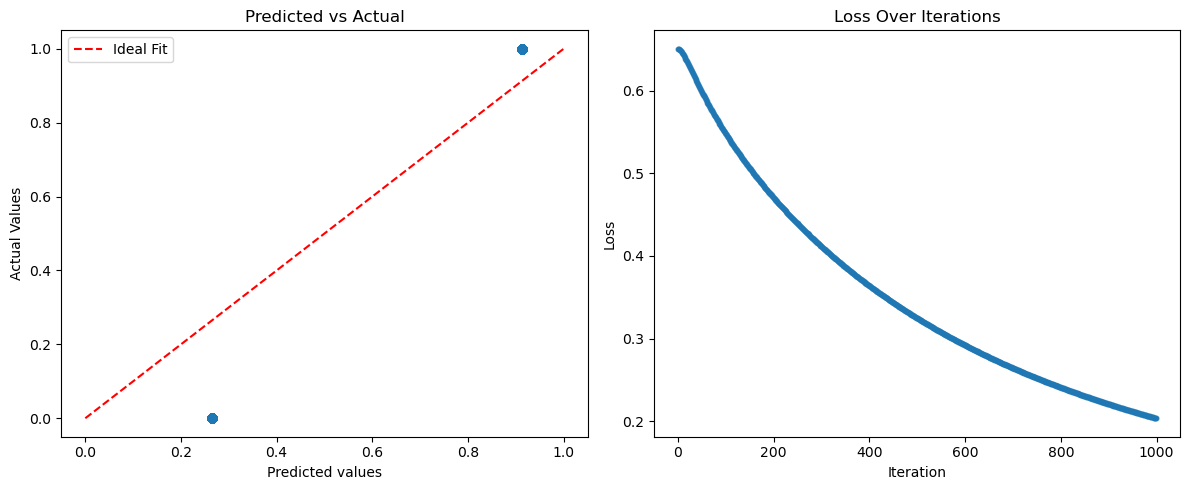

Model Summary
--------------------------------------------------
Confusion Matrix


,0,1
0,257,0
1,0,243


Accuracy = 1.0
Precision = 1.0
Recall = 1.0
Log-Loss = 0.20345015918530027


,Variable,Coefficient
0,x1,1.680326
1,bias,-1.016285


In [ ]:
univariate_model = logistic_regression(data, y_name='target', x_names='x1')
univariate_model.train()
univariate_model.summary()

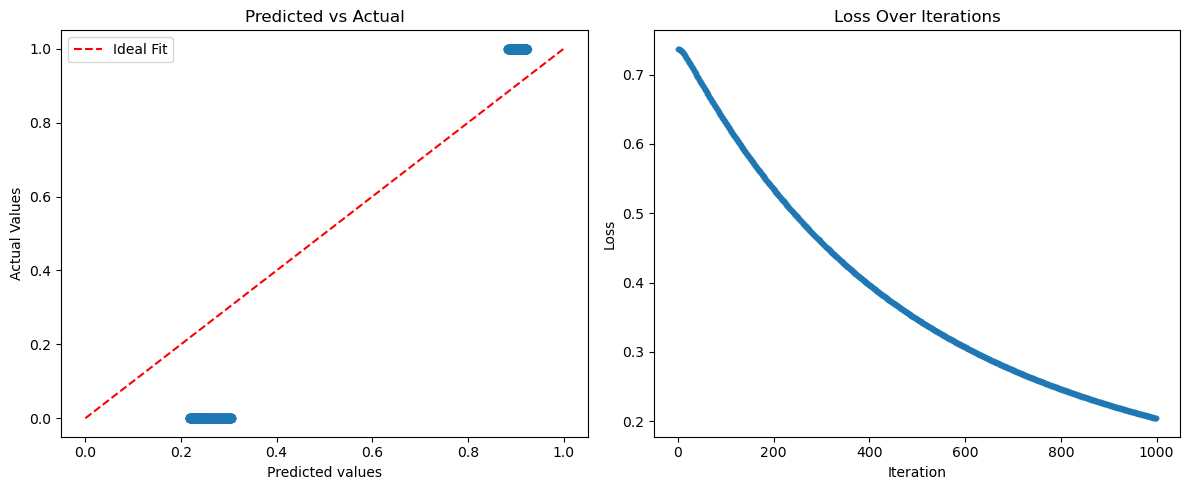

Model Summary
--------------------------------------------------
Confusion Matrix


,0,1
0,257,0
1,0,243


Accuracy = 1.0
Precision = 1.0
Recall = 1.0
Log-Loss = 0.2043588595360957


,Variable,Coefficient
0,x1,1.650512
1,x2,-0.451708
2,bias,-0.820924


In [ ]:
multivariate_model = logistic_regression(data, y_name='target', x_names=('x1', 'x2'))
multivariate_model.train()
multivariate_model.summary()